<a href="https://colab.research.google.com/github/Ni-cole17/Diabetes-IA/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Direcionamento ao diretório e importação de bibliotecas







In [1]:
%cd /content/drive/My Drive/Bases

/content/drive/My Drive/Bases


In [2]:
from scipy.io import arff
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

### Importação da base de dados em arff

In [73]:
data = arff.loadarff('diabetes.arff')
df_diabetes = pd.DataFrame(data[0])

### Visualização inicial da base de dados e dos seus atributos

In [74]:
df_diabetes.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


A base de dados acima irá ser utilizada para prever se uma pessoa é mais provável de ter diabetes dados alguns fatores como: 
- Número de gestações (preg)
- Nível de glicose no plasma sanguíneo (plas)
- Pressão arterial diastólica (pres)
- Espessura da dobra cutânea (skin)
- Nível de insulina em U/ml (insu)
- Índice de massa corporal (mass)
- Probabilidade de diabetes com base na história familiar (pedi)
- Idade da pessoa (age).

### Verificando se tem algum dado nulo na base de dados

In [75]:
df_diabetes.info()  # A classe dessa base de dados é do tipo object, vou precisar transformar para o tipo inteiro para a classificação

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    float64
 1   plas    768 non-null    float64
 2   pres    768 non-null    float64
 3   skin    768 non-null    float64
 4   insu    768 non-null    float64
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    float64
 8   class   768 non-null    object 
dtypes: float64(8), object(1)
memory usage: 54.1+ KB


In [76]:
df_diabetes.isnull().sum() # A base de dados não possui nenhum dado nulo, logo não precisará de um tratamento nos dados para retirar nulos.

preg     0
plas     0
pres     0
skin     0
insu     0
mass     0
pedi     0
age      0
class    0
dtype: int64

Após fazer a separação dos dados, antes de ir para a etapa de classificação, vamos entender como cada um dos atributos afetam a diabetes.

### Distribuição das variáveis

In [77]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=4, cols=2,subplot_titles=("Distribuição Etária","Distribuição por IMC","Distribuição por # de Gestações","Distribuição por prob. de diabetes","Nível de insulina em U/ml","Nível de glicose no plasma sanguíneo","Espessura da dobra cutânea","Pressão arterial diastólica"))
fig.add_trace(go.Histogram(x=df_diabetes['age']), row=1, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['mass']), row=1, col=2)
fig.add_trace(go.Histogram(x=df_diabetes['preg']), row=2, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['pedi']), row=2, col=2)
fig.add_trace(go.Histogram(x=df_diabetes['insu']), row=3, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['plas']), row=3, col=2)
fig.add_trace(go.Histogram(x=df_diabetes['skin']), row=4, col=1)
fig.add_trace(go.Histogram(x=df_diabetes['pres']), row=4, col=2)
fig.show()

Essa distribuição melhora a visualização de outliers. Logo, os próximos passos é identificar outliers em cada uma das features.

Uma delas que indica muito possivelmente a presença de outliers é a feature Pressão arterial diastólica, visto que vemos no gráfico que existem valores entre 0-4. No entanto, olhando do ponto de vista biológico, é impossível que uma pessoa que esteja viva tenha uma pressão diastólica nesses valores. Em geral a pressão diastólica do ser humano varia de valores entre 60-90.

In [78]:
df_diabetes['pres'].describe()

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: pres, dtype: float64

In [79]:
pres_outlier = df_diabetes.query('pres < 30')
pres_outlier

,preg,plas,pres,skin,insu,mass,pedi,age,class
7,10.0,115.0,0.0,0.0,0.0,35.3,0.134,29.0,b'tested_negative'
15,7.0,100.0,0.0,0.0,0.0,30.0,0.484,32.0,b'tested_positive'
49,7.0,105.0,0.0,0.0,0.0,0.0,0.305,24.0,b'tested_negative'
60,2.0,84.0,0.0,0.0,0.0,0.0,0.304,21.0,b'tested_negative'
78,0.0,131.0,0.0,0.0,0.0,43.2,0.270,26.0,b'tested_positive'
81,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,b'tested_negative'
172,2.0,87.0,0.0,23.0,0.0,28.9,0.773,25.0,b'tested_negative'
193,11.0,135.0,0.0,0.0,0.0,52.3,0.578,40.0,b'tested_positive'
222,7.0,119.0,0.0,0.0,0.0,25.2,0.209,37.0,b'tested_negative'
261,3.0,141.0,0.0,0.0,0.0,30.0,0.761,27.0,b'tested_positive'


Outra feature que tem possívelmente outliers é a distribuição por IMC, que aparenta ter valores negativos ou muito baixos.


In [80]:
df_diabetes['mass'].describe()

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: mass, dtype: float64

In [81]:
mass_outlier = df_diabetes.query('mass < 10')
mass_outlier

,preg,plas,pres,skin,insu,mass,pedi,age,class
9,8.0,125.0,96.0,0.0,0.0,0.0,0.232,54.0,b'tested_positive'
49,7.0,105.0,0.0,0.0,0.0,0.0,0.305,24.0,b'tested_negative'
60,2.0,84.0,0.0,0.0,0.0,0.0,0.304,21.0,b'tested_negative'
81,2.0,74.0,0.0,0.0,0.0,0.0,0.102,22.0,b'tested_negative'
145,0.0,102.0,75.0,23.0,0.0,0.0,0.572,21.0,b'tested_negative'
371,0.0,118.0,64.0,23.0,89.0,0.0,1.731,21.0,b'tested_negative'
426,0.0,94.0,0.0,0.0,0.0,0.0,0.256,25.0,b'tested_negative'
494,3.0,80.0,0.0,0.0,0.0,0.0,0.174,22.0,b'tested_negative'
522,6.0,114.0,0.0,0.0,0.0,0.0,0.189,26.0,b'tested_negative'
684,5.0,136.0,82.0,0.0,0.0,0.0,0.640,69.0,b'tested_negative'


Observando essas duas análises, vemos que existem muitos dados que tem uma linha com 3 zeros ou mais, isso quer dizer, com dados faltantes, isso não é benéfico para nossa posterior classificação, logo esses dados com mais de 3 zeros irei deletar do data frame.

In [82]:
indexes = []
for i in range(len(df_diabetes)):
  linha = list(df_diabetes.iloc[i])
  zeros = linha.count(0)
  if zeros > 3:
    indexes.append(i)
df_diabetes_new = df_diabetes.drop(df_diabetes.index[indexes])
df_diabetes_new

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [83]:
df_diabetes_new['insu'].value_counts()

0.0      358
105.0     11
130.0      9
140.0      9
120.0      8
        ... 
73.0       1
171.0      1
255.0      1
52.0       1
112.0      1
Name: insu, Length: 186, dtype: int64

In [84]:
df_diabetes_new = df_diabetes_new.drop(columns=['insu'])
df_diabetes_new

,preg,plas,pres,skin,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,30.1,0.349,47.0,b'tested_positive'


Após excluir uma coluna com muitos dados faltantes e retirar da nossa base de dados linhas com muitos dados iguais a 0. Vou substituir dados iguais a zero de algumas colunas pela média dos valores da coluna. Nesse caso, só foram substituídos os 0 em colunas que não faria sentido aquele dado ser 0. (mass,plas e pres)

In [85]:
df_diabetes_new.mass.mean()

32.26010638297872

In [86]:
df_diabetes_new.loc[df_diabetes_new.mass == 0,'mass'] = df_diabetes_new.mass.mean()

In [87]:
df_diabetes_new.loc[df_diabetes_new.plas == 0,'plas'] = df_diabetes_new.plas.mean()

In [88]:
df_diabetes_new.loc[df_diabetes_new.pres == 0,'pres'] = df_diabetes_new.pres.mean()

In [89]:
df_diabetes_new

,preg,plas,pres,skin,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [90]:
fig = make_subplots(rows=4, cols=2,subplot_titles=("Distribuição Etária","Distribuição por IMC","Distribuição por # de Gestações","Distribuição por prob. de diabetes","Nível de glicose no plasma sanguíneo","Espessura da dobra cutânea","Pressão arterial diastólica"))
fig.add_trace(go.Histogram(x=df_diabetes_new['age']), row=1, col=1)
fig.add_trace(go.Histogram(x=df_diabetes_new['mass']), row=1, col=2)
fig.add_trace(go.Histogram(x=df_diabetes_new['preg']), row=2, col=1)
fig.add_trace(go.Histogram(x=df_diabetes_new['pedi']), row=2, col=2)
fig.add_trace(go.Histogram(x=df_diabetes_new['plas']), row=3, col=1)
fig.add_trace(go.Histogram(x=df_diabetes_new['skin']), row=3, col=2)
fig.add_trace(go.Histogram(x=df_diabetes_new['pres']), row=4, col=1)
fig.show()

Observando os gráficos acima, jé vemos uma distribuição bem melhor e mais coerente dos dados.

In [91]:
nomes_linhas = dict()
for i in range(df_diabetes_new.shape[0]):
  nomes_linhas[df_diabetes_new.index[i]] = i

In [92]:
df_diabetes_new = df_diabetes_new.rename(index=nomes_linhas)

In [93]:
df_diabetes_new.tail()

,preg,plas,pres,skin,mass,pedi,age,class
747,10.0,101.0,76.0,48.0,32.9,0.171,63.0,b'tested_negative'
748,2.0,122.0,70.0,27.0,36.8,0.340,27.0,b'tested_negative'
749,5.0,121.0,72.0,23.0,26.2,0.245,30.0,b'tested_negative'
750,1.0,126.0,60.0,0.0,30.1,0.349,47.0,b'tested_positive'
751,1.0,93.0,70.0,31.0,30.4,0.315,23.0,b'tested_negative'


### Explorando um pouco mais o dataset

#### Quantas pessoas com diabetes tem mais que 60 anos?

In [94]:
df_diabetes_new['classb'] = df_diabetes_new['class'].replace(b'tested_positive',1)
df_diabetes_new['classb'] = df_diabetes_new['classb'].replace(b'tested_negative',0)
df_diabetes_new.head()

,preg,plas,pres,skin,mass,pedi,age,class,classb
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0,b'tested_positive',1
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0,b'tested_negative',0
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0,b'tested_positive',1
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0,b'tested_negative',0
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0,b'tested_positive',1


In [95]:
idosos_diabetes = df_diabetes_new.query('age > 60 and classb == 1').shape[0]
idosos_diabetes

7

In [96]:
idosos_nodiabetes = df_diabetes_new.query('age > 60 and classb == 0').shape[0]
idosos_nodiabetes

20

Os idosos com diabetes nessa base de dados representa cerca de 1% dos dados da base de dados.

#### O quão balanceado está nossa classe?

In [97]:
df_age_diabetes = df_diabetes_new.query('classb == 1')
df_age_nodiabetes = df_diabetes_new.query('classb == 0')

In [98]:
positive = df_age_diabetes.shape[0]
negative = df_age_nodiabetes.shape[0]
print("Positivo: {} \nNegativo: {}".format(positive,negative))

Positivo: 261 
Negativo: 491


Temos um dataset bem desbalanceado, temos muito mais a classe negativo do que a classe positivo para diabetes. Se isso for um input para um IA, ela pode aprender muito mais a classificar para um caso negativo do que para um caso positivo. Logo creio que vale a pena explorar técnicas para balanceamento de classes. Nesse caso vou utilizar o SMOTE, visto que já utilizei ele anteriormente em outros problemas.

#### Onde está a maior incidência de diabetes de acordo com a idade nesse dataset?

In [99]:
df_age_diabetes = df_diabetes_new.query('classb == 1')

In [100]:
fig = px.histogram(df_age_diabetes, x="age")
fig.show()

No nosso dataset temos que a maior parte das pessoas diabéticas estão entre 20-40 anos. Mesmo que seja mais comum pessoas mais velhas estarem associadas à diabetes, o dataset não apresenta muito esse padrão. Creio que isso seja em face do dataset não explorar somente a idade como fator determinante para uma pessoa ser positiva para diabetes. Por isso, existem pessoas mais jovens diabéticas, o que não caracteriza o cenário global.

#### Análise estatística dos parâmetros em relação a classe

In [101]:
fig = make_subplots(rows=7, cols=2,subplot_titles=("Distribuição Etária","Distribuição Etária","Distribuição por IMC","Distribuição por IMC","Distribuição por # de Gestações","Distribuição por # de Gestações","Distribuição por prob. de diabetes","Distribuição por prob. de diabetes","Nível de glicose no plasma sanguíneo","Nível de glicose no plasma sanguíneo","Espessura da dobra cutânea","Espessura da dobra cutânea","Pressão arterial diastólica","Pressão arterial diastólica"))
fig.add_trace(go.Histogram(x=df_age_nodiabetes['age']), row=1, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['age']), row=1, col=2)

fig.add_trace(go.Histogram(x=df_age_nodiabetes['mass']), row=2, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['mass']), row=2, col=2)

fig.add_trace(go.Histogram(x=df_age_nodiabetes['preg']), row=3, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['preg']), row=3, col=2)

fig.add_trace(go.Histogram(x=df_age_nodiabetes['pedi']), row=4, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['pedi']), row=4, col=2)

fig.add_trace(go.Histogram(x=df_age_nodiabetes['plas']), row=5, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['plas']), row=5, col=2)

fig.add_trace(go.Histogram(x=df_age_nodiabetes['skin']), row=6, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['skin']), row=6, col=2)

fig.add_trace(go.Histogram(x=df_age_nodiabetes['pres']), row=7, col=1)
fig.add_trace(go.Histogram(x=df_age_diabetes['pres']), row=7, col=2)

fig.update_layout(height=1000, width=1300, title_text="Comparação da distribuição entre pessoas sem diabetes e com diabetes")
fig.show()

In [102]:
fig = make_subplots(rows=7, cols=1,subplot_titles=("Distribuição Etária","Distribuição por IMC","Distribuição por # de Gestações","Distribuição por prob. de diabetes","Nível de glicose no plasma sanguíneo","Espessura da dobra cutânea","Pressão arterial diastólica"))

fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['age']), row=1, col=1)
fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['mass']), row=2, col=1)
fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['preg']), row=3, col=1)
fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['pedi']), row=4, col=1)
fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['plas']), row=5, col=1)
fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['skin']), row=6, col=1)
fig.add_trace(go.Box(x=df_diabetes_new['classb'],y=df_diabetes_new['pres']), row=7, col=1)




fig.update_layout(height=3000, width=1500, title_text="Comparação da distribuição entre pessoas sem diabetes (0) e com diabetes (1)")
fig.show()

Analisando o histograma e os gráficos do tipo boxplot, que vão dar uma visão mais estatística dos dados temos que:
Age: Grande parte das pessoas sem diabetes estão mais concentradas entre 20-30 anos, já os diabéticos possuem uma média de idade um pouco acima e com a dispersão dos dados mais simétrica. No entanto, não podemos associar diretamente que essa *feature* é determinante para a classificação, embora tenha o padrão de que pessoas mais velhas são mais propícias à terem diabetes.

O IMC vemos que para ambos temos uma dispersão dos dados parecida, no entanto, para os diabéticos temos uma elevação do gráfico boxplot, isto é, uma média e uma mediana maior. O que mostra que os diabéticos do dataset possuem um IMC maior. 

O número de gestãções parece ser um parâmetro bastante relevante para a classificação. A maior parte (75%) das mulheres sem diabetes tiveram até 5 filhos e 50% delas (mediana) tiveram até 2 filhos, enquanto que para mulheres com diabetes (75%) tiveram até 8 filhos.

Para a espessura da dobra cutânea e para a pressão arterial, observamos aproximadamente o mesmo padrão, sem muitas diferenças em relação à análie estatística.

A *feature* talvez mais óbvia de possuir um grande diferencial entre diabéticos e não diabéticos é o nível de glicose no plasma sanguíneo, visto que esse parâmetro muitas vezes no meio médico é um dos principais fatores para o diagnóstico da diabetes. De fato, encontramos essa característica, visto que vemos o gráfico boxplot bem mais elevado para os diabéticos.

### Separação da base de dados em seus atributos (X) e classe (Y)

In [103]:
X = df_diabetes_new.loc[:,['preg', 'plas', 'pres', 'skin', 'mass', 'pedi', 'age']]
X

,preg,plas,pres,skin,mass,pedi,age
0,6.0,148.0,72.0,35.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,43.1,2.288,33.0
...,...,...,...,...,...,...,...
747,10.0,101.0,76.0,48.0,32.9,0.171,63.0
748,2.0,122.0,70.0,27.0,36.8,0.340,27.0
749,5.0,121.0,72.0,23.0,26.2,0.245,30.0
750,1.0,126.0,60.0,0.0,30.1,0.349,47.0


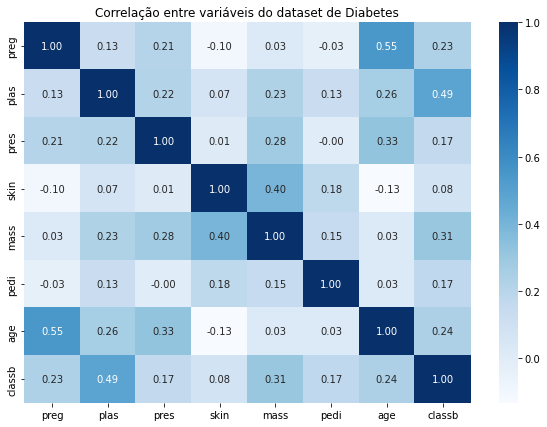

In [104]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_diabetes_new.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset de Diabetes')
plt.show()

Ainda nesse tratamento do data frame temos uma coluna que é o Nível de insulina em U/ml, no entanto, vemos que grande parte dos seus valores são nulos, logo não vejo como uma coluna que será interessante no dataframe, logo irei retirá-la.

As variáveis que tiveram mais correlação acima foram:

Número de Gestações e Idade: De fato essas duas variáveis podem estar relacionadas visto que é mais comum que mulheres mais velhas tenham mais filhos que mulheres mais jovens.

IMC e Dobra Cutânea também são variáveis bem correlacionadas visto que quanto maior o IMC mais provável ter uma dobra cutânea maior também.

In [105]:
Y = df_diabetes_new.loc[:,['class']]
Y

,class
0,b'tested_positive'
1,b'tested_negative'
2,b'tested_positive'
3,b'tested_negative'
4,b'tested_positive'
...,...
747,b'tested_negative'
748,b'tested_negative'
749,b'tested_negative'
750,b'tested_positive'


In [106]:
Y['class'] = Y['class'].replace(b'tested_negative',0)
Y['class'] = Y['class'].replace(b'tested_positive',1)
Y

,class
0,1
1,0
2,1
3,0
4,1
...,...
747,0
748,0
749,0
750,1


### Aplicando o balanceamento de classes

In [107]:
sm = SMOTE()
X, y = sm.fit_resample(X, Y)

In [108]:
X

,preg,plas,pres,skin,mass,pedi,age
0,6.000000,148.000000,72.000000,35.000000,33.600000,0.627000,50.000000
1,1.000000,85.000000,66.000000,29.000000,26.600000,0.351000,31.000000
2,8.000000,183.000000,64.000000,0.000000,23.300000,0.672000,32.000000
3,1.000000,89.000000,66.000000,23.000000,28.100000,0.167000,21.000000
4,0.000000,137.000000,40.000000,35.000000,43.100000,2.288000,33.000000
...,...,...,...,...,...,...,...
977,2.208245,95.604122,80.187633,25.604122,35.181237,0.276799,45.718551
978,9.192298,164.769192,77.230808,0.000000,33.799949,0.222804,42.884723
979,1.129579,180.847185,90.000000,27.270777,36.217605,0.329391,35.282395
980,7.000000,189.815462,68.000000,34.575702,36.976024,0.451485,41.000000


In [109]:
y

,class
0,1
1,0
2,1
3,0
4,1
...,...
977,1
978,1
979,1
980,1


### Separação do dataset em Treino e Teste

In [110]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100,shuffle=True)

In [111]:
print(X_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(657, 7) (657, 1)
(325, 7) (325, 1)


### Utilizando modelos de aprendizado supervisionado

#### SVM

Para cada treinamento, irei utilizar cross_validation com 10 folds

In [125]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [127]:
def cross_validation(model, _X, _y, _cv=10):
  _scoring = ['accuracy', 'precision', 'recall', 'f1']
  _y = np.ravel(_y)
  results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
  return results['train_accuracy']
  
  '''{"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }'''

In [142]:
kernels = ['rbf','linear','poly']
Cs = [1,0.1,0.01]
polys = [2,3]
results = []
dicionario = {}
for kernel in kernels:
  if kernel == 'poly':
    for poly in polys:
      for c in Cs:
        clf = svm.SVC(kernel=kernel,C=c,degree=poly)
        cv = ShuffleSplit(train_size=0.66,n_splits=10, test_size=0.33, random_state=10)
        results = cross_validation(clf, X, y, _cv=10)
        dicionario[f'{kernel}_{poly}_{c}'] = results
      results = []
  else:
    for c in Cs:
      clf = svm.SVC(kernel=kernel,C=c)
      cv = ShuffleSplit(train_size=0.66,n_splits=10, test_size=0.33, random_state=10)
      results = cross_validation(clf, X, y, _cv=10)
      dicionario[f'{kernel}_{c}'] = results
    results = []

  

In [143]:
dicionario

{'rbf_1': array([0.74405436, 0.73499434, 0.73190045, 0.739819  , 0.72058824,
        0.72963801, 0.7341629 , 0.73642534, 0.72737557, 0.73755656]),
 'rbf_0.1': array([0.72706682, 0.71460929, 0.7239819 , 0.7239819 , 0.70927602,
        0.71719457, 0.72171946, 0.72171946, 0.71493213, 0.71606335]),
 'rbf_0.01': array([0.69082673, 0.70894677, 0.71606335, 0.71719457, 0.70475113,
        0.71153846, 0.71719457, 0.71266968, 0.70135747, 0.70588235]),
 'linear_1': array([0.76217441, 0.73272933, 0.75339367, 0.75904977, 0.739819  ,
        0.75113122, 0.739819  , 0.75565611, 0.74660633, 0.74434389]),
 'linear_0.1': array([0.7610419 , 0.73612684, 0.75      , 0.75226244, 0.74095023,
        0.74660633, 0.73642534, 0.75      , 0.74208145, 0.73642534]),
 'linear_0.01': array([0.75084938, 0.73272933, 0.75113122, 0.74886878, 0.72963801,
        0.73642534, 0.73303167, 0.75678733, 0.73529412, 0.73303167]),
 'poly_2_1': array([0.73499434, 0.71347678, 0.73076923, 0.7341629 , 0.71719457,
        0.71606335,

#### Random Forest

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

trees = [10,50,100]
for tree in trees:
  clf = RandomForestClassifier(n_estimators=tree,max_depth=2, random_state=0)
  cv = ShuffleSplit(train_size=0.66,n_splits=10, test_size=0.33, random_state=10)
  dicionario[f'Random_forest_{tree}'] = cross_validation(clf, X, y,cv)


In [154]:
dicionario

{'rbf_1': array([0.74405436, 0.73499434, 0.73190045, 0.739819  , 0.72058824,
        0.72963801, 0.7341629 , 0.73642534, 0.72737557, 0.73755656]),
 'rbf_0.1': array([0.72706682, 0.71460929, 0.7239819 , 0.7239819 , 0.70927602,
        0.71719457, 0.72171946, 0.72171946, 0.71493213, 0.71606335]),
 'rbf_0.01': array([0.69082673, 0.70894677, 0.71606335, 0.71719457, 0.70475113,
        0.71153846, 0.71719457, 0.71266968, 0.70135747, 0.70588235]),
 'linear_1': array([0.76217441, 0.73272933, 0.75339367, 0.75904977, 0.739819  ,
        0.75113122, 0.739819  , 0.75565611, 0.74660633, 0.74434389]),
 'linear_0.1': array([0.7610419 , 0.73612684, 0.75      , 0.75226244, 0.74095023,
        0.74660633, 0.73642534, 0.75      , 0.74208145, 0.73642534]),
 'linear_0.01': array([0.75084938, 0.73272933, 0.75113122, 0.74886878, 0.72963801,
        0.73642534, 0.73303167, 0.75678733, 0.73529412, 0.73303167]),
 'poly_2_1': array([0.73499434, 0.71347678, 0.73076923, 0.7341629 , 0.71719457,
        0.71606335,